# P50 Paired-click

Design:

* trial: two auditory clicks, 500 ms SOA 
* several seconds between trials, random ITI 

In [1]:
import os
import sys
from pathlib import Path
import re
import numpy as np
import pandas as pd
import mkpy
import spudtr

from matplotlib import pyplot as plt
from mkpy import mkh5
from spudtr import epf

# path wrangling for nbsphinx
if "MDE_HOME" in os.environ.keys():
    MDE_HOME = Path(os.environ["MDE_HOME"])
else:
    from conf import MDE_HOME

print(os.environ["CONDA_DEFAULT_ENV"])
print(sys.version)
for pkg in [np, pd, mkpy, spudtr]:
    print(pkg.__name__, pkg.__version__, pkg.__file__)

spudtrE
3.8.2 (default, Mar 26 2020, 15:53:00) 
[GCC 7.3.0]
numpy 1.19.1 /home/turbach/miniconda3/envs/spudtrE/lib/python3.8/site-packages/numpy/__init__.py
pandas 1.1.3 /home/turbach/miniconda3/envs/spudtrE/lib/python3.8/site-packages/pandas/__init__.py
mkpy 0.2.4.dev3 /home/turbach/miniconda3/envs/spudtrE/lib/python3.8/site-packages/mkpy/__init__.py
spudtr 0.0.11.dev0 /mnt/cube/home/turbach/TPU_Projects/spudtr/spudtr/__init__.py


In [2]:
# set recorded ERPSS data filenames
crw = MDE_HOME / "mkdig/sub000p5.crw"    # EEG recording
log = MDE_HOME / "mkdig/sub000p5.x.log"  # events 
yhdr = MDE_HOME / "mkpy/sub000p5.yhdr"   # extra header info

# set calibration data filenames
cals_crw = MDE_HOME / "mkdig/sub000c5.crw"
cals_log = MDE_HOME / "mkdig/sub000c5.x.log"
cals_yhdr = MDE_HOME / "mkpy/sub000c5.yhdr"

# HDF5 file with EEG recording, events, and header
p50_h5_f = MDE_HOME / "data/sub000p50.h5"  

**mkh5**  EEG data, event code log, header information

In [3]:
p50_h5 = mkh5.mkh5(p50_h5_f)  # make ready

p50_h5.reset_all()  # wipe previous
p50_h5.create_mkdata("sub000", crw, log, yhdr) # convert the data to HDF5

# add calibration data to this subject
p50_h5.append_mkdata("sub000", cals_crw, cals_log, cals_yhdr)

# set calibration parameters and calibrate
pts, pulse, lo, hi, ccode = 5, 10, -40, 40, 0
p50_h5.calibrate_mkdata(
    "sub000",  # data group to calibrate with these cal pulses
    n_points=pts,  # pts to average
    cal_size=pulse,  # uV
    lo_cursor=lo,  # lo_cursor ms
    hi_cursor=hi,  # hi_cursor ms
    cal_ccode=ccode,  # condition code
)

/home/turbach/miniconda3/envs/spudtrE/lib/python3.8/site-packages/mkpy/mkh5.py:3630: UserWarning: negative event code(s) found for cal condition code 0 -16384
  warnings.warn(msg)


Found cals in /sub000/dblock_2
Calibrating block /sub000/dblock_0 of 3: (219904,)  
Calibrating block /sub000/dblock_1 of 3: (225280,)  
Calibrating block /sub000/dblock_2 of 3: (56064,)  


**codemap**

For this simple design the codemap a few lines of hand-typed YAML.

The tag column labels are for illustration, `bin` is used because it can be, not because it must.

The calibration events are included for comparison

In [4]:
%%bash
head -14 $MDE_HOME/mkpy/p50_codemap.ytbl

# mkpy YAML codemap
#
# columns and rows must align, regexp is a mandatory column, all else is whatever

---
name: p5

columns:
    [ regexp,  ccode,  instrument,   bin,      click,    type          ]
rows:
  - ['(#\d+)',     0,         cal,     0,        cal,    cal           ]
  - ['(#1)',       1,         eeg,     1,    click_1,    conditioning  ]
  - ['(#2)',       1,         eeg,     2,    click_2,    test          ]



**1. get_event_table(*codemap*)** 

Scan the event codes for pattern matches and collect the HDF5 index, matching code, and tags

Event table modifications are not needed for this simple design.

In [5]:
p50_event_table = p50_h5.get_event_table(MDE_HOME / "mkpy/p50_codemap.ytbl")

/home/turbach/miniconda3/envs/spudtrE/lib/python3.8/site-packages/mkpy/mkh5.py:1046: UserWarning: 
As of mkpy 0.2.0 to match events with a codemap regexp pattern, the
ccode column in p50_codemap.ytbl must also match the log_ccode
in the datablock. If this behavior is not desired, delete or rename
the ccode column in the codemap.
  warnings.warn(msg)


searching codes in: sub000/dblock_0
searching codes in: sub000/dblock_1
searching codes in: sub000/dblock_2


**inspect the event table**

Check that the codemap scan returned all and only the correct events and tags.

In [6]:
print("event table shape:", p50_event_table.shape)
print("event table columns:", p50_event_table.columns.to_list())

# select some columns to show
example_columns = [
    "dblock_path", "dblock_ticks", "log_evcodes", "log_ccodes", "log_flags", 
    "regexp", "match_code", "instrument", "bin", "click", "type"
]

# first few stimulus events
display(p50_event_table[example_columns].head())

# last few calibration pulse events
display(p50_event_table[example_columns].tail())

# tally and check event counts 
pd.crosstab(
    index=[
        p50_event_table.ccode, 
        p50_event_table.instrument, 
        p50_event_table.bin,
        p50_event_table.click,
    ],
    columns=[
        p50_event_table.log_flags,
    ],
    margins=True
)

event table shape: (448, 29)
event table columns: ['data_group', 'dblock_path', 'dblock_tick_idx', 'dblock_ticks', 'crw_ticks', 'raw_evcodes', 'log_evcodes', 'log_ccodes', 'log_flags', 'epoch_match_tick_delta', 'epoch_ticks', 'dblock_srate', 'match_group', 'idx', 'dlim', 'anchor_str', 'match_str', 'anchor_code', 'match_code', 'anchor_tick', 'match_tick', 'anchor_tick_delta', 'is_anchor', 'regexp', 'ccode', 'instrument', 'bin', 'click', 'type']


,dblock_path,dblock_ticks,log_evcodes,log_ccodes,log_flags,regexp,match_code,instrument,bin,click,type
120,sub000/dblock_0,606,1,1,0,(#1),1,eeg,1,click_1,conditioning
121,sub000/dblock_0,3792,1,1,0,(#1),1,eeg,1,click_1,conditioning
122,sub000/dblock_0,7714,1,1,0,(#1),1,eeg,1,click_1,conditioning
123,sub000/dblock_0,10771,1,1,0,(#1),1,eeg,1,click_1,conditioning
124,sub000/dblock_0,13980,1,1,0,(#1),1,eeg,1,click_1,conditioning


,dblock_path,dblock_ticks,log_evcodes,log_ccodes,log_flags,regexp,match_code,instrument,bin,click,type
683,sub000/dblock_2,54179,4,0,0,(#\d+),4,cal,0,cal,cal
684,sub000/dblock_2,54437,2,0,0,(#\d+),2,cal,0,cal,cal
685,sub000/dblock_2,54695,3,0,0,(#\d+),3,cal,0,cal,cal
686,sub000/dblock_2,54954,4,0,0,(#\d+),4,cal,0,cal,cal
687,sub000/dblock_2,55212,2,0,0,(#\d+),2,cal,0,cal,cal


log_flags                       0  32  48  64  All
ccode instrument bin click                        
0     cal        0   cal      207   0   0   1  208
1     eeg        1   click_1  117   3   0   0  120
                 2   click_2  114   5   1   0  120
All                           438   8   1   1  448

**2. set_epochs(*name*, *pre*, *post*)**

Stash the the event table events and tags with a name and epoch interval boundaries.

In [7]:
p50_h5.set_epochs("ms1500", p50_event_table, -750, 750)

Sanitizing event table data types for mkh5 epochs table ...


/home/turbach/miniconda3/envs/spudtrE/lib/python3.8/site-packages/mkpy/mkh5.py:1501: UserWarning: data error: pre-stimulus interval is out of bounds left ... skipping epoch (240, b'sub000', b'sub000/dblock_2', 0, 360, 360, 1, 1, 0, 64, -375, 750, 500., 1, 0, 1, b'1', b'1', 1, 1, 360, 360, 0, True, b'(#\\d+)', 0, b'cal', 0, b'cal', b'cal', 0, 0, 0, 360, -375, 750)
  warnings.warn(


**3. export_epochs(*name*, *file_format=...*)** 

Export the time-stamped, tagged, fixed-length segments of EEG data for analysis as HDF5, pandas HDF5 or feather

In [8]:
# this exports the epochs DATA ... indexed, timstamped, EEG, events, and tags.
p50_h5.export_epochs("ms1500", MDE_HOME / "data/sub000p50.ms1500.epochs.feather", file_format="feather")        

**analyze epochs**

In [12]:
p50_epochs = pd.read_feather(MDE_HOME / "data/sub000p50.ms1500.epochs.feather")

# sanitize epoch_id for pandas index
p50_epochs['epoch_id'] = p50_epochs['epoch_id'].astype('int')

# look up pattern-matched events with timestamp 0
p50_events = p50_epochs.query("match_time==0")
p50_counts = pd.crosstab(
    [p50_events.instrument, p50_events.ccode, p50_events.bin, p50_events.click, p50_events.type],
    [p50_events.log_flags],
    margins=True
)

# lookup scalp potential channels ... EEG, EOG, A2 
p50_chans = [col for col in p50_epochs.columns if re.match(r"^[MLRAHlr]\w{1,3}$", col)]
p50_chandesc = ""
for i, c in enumerate(p50_chans):
    sep = " " if i % 8 < 7 else "\n"
    p50_chandesc += f"{i:2d}:{c:4s}{sep}"

print(f"channels: {len(p50_chans)}\nchdesc:{p50_chandesc}")
display(p50_counts)

channels: 32
chdesc: 0:lle   1:lhz   2:MiPf  3:LLPf  4:RLPf  5:LMPf  6:RMPf  7:LDFr
 8:RDFr  9:LLFr 10:RLFr 11:LMFr 12:RMFr 13:LMCe 14:RMCe 15:MiCe
16:MiPa 17:LDCe 18:RDCe 19:LDPa 20:RDPa 21:LMOc 22:RMOc 23:LLTe
24:RLTe 25:LLOc 26:RLOc 27:MiOc 28:A2   29:HEOG 30:rle  31:rhz 



log_flags                                    0  32  48  All
instrument ccode bin click   type                          
cal        0     0   cal     cal           207   0   0  207
eeg        1     1   click_1 conditioning  117   3   0  120
                 2   click_2 test          114   5   1  120
All                                        438   8   1  447

In [13]:
# for illustration ... cal pulses and first click
midline = ["MiPf", "MiCe", "MiPa", "MiOc"]
bins = p50_epochs.bin.unique()

midline_epochs = p50_epochs[
    ["epoch_id", "click", "match_time"] + midline
].query("click in ['cal', 'click_1']")

# center each channel 
midline_epochs = epf.center_eeg(
    midline_epochs, 
    midline, 
    -100, 0, 
    epoch_id="epoch_id", 
    time="match_time"
)

In [14]:
# look up single trial click_2 event timestamp relative to click_1 onset (match_time)
click2_onsets = p50_epochs.query(
    "ccode > 0 and match_code == 1 and log_evcodes == 2"
).match_time

click2_onset = int(np.round(click2_onsets.mean(), 0))

display(click2_onsets.value_counts())
display(click2_onsets.describe())
display(click2_onset)


502    101
506      7
504      7
500      5
Name: match_time, dtype: int64

count    120.000000
mean     502.266667
std        1.128197
min      500.000000
25%      502.000000
50%      502.000000
75%      502.000000
max      506.000000
Name: match_time, dtype: float64

502

**time-domain average paired-click ERPs**

The 10 microvolt calibration square is for illustration.

In [15]:
midline_erps = midline_epochs.groupby(["click", "match_time"]).mean().reset_index()
midline_erps

,click,match_time,epoch_id,MiPf,MiCe,MiPa,MiOc
0,cal,-750,344.0,0.031777,0.030263,-0.008570,-0.021974
1,cal,-748,344.0,0.026993,0.027894,-0.053359,-0.093315
2,cal,-746,344.0,0.034188,0.004735,-0.031715,-0.074623
3,cal,-744,344.0,0.036570,0.013279,-0.016684,-0.045383
4,cal,-742,344.0,0.027017,0.016949,0.012113,-0.041882
...,...,...,...,...,...,...,...
1495,click_1,740,89.5,-3.296837,-4.691502,-1.160323,0.269139
1496,click_1,742,89.5,-3.073172,-4.794128,-1.390727,0.152291
1497,click_1,744,89.5,-2.999067,-5.094552,-1.737775,-0.031446
1498,click_1,746,89.5,-3.031741,-5.235142,-1.946156,-0.063351


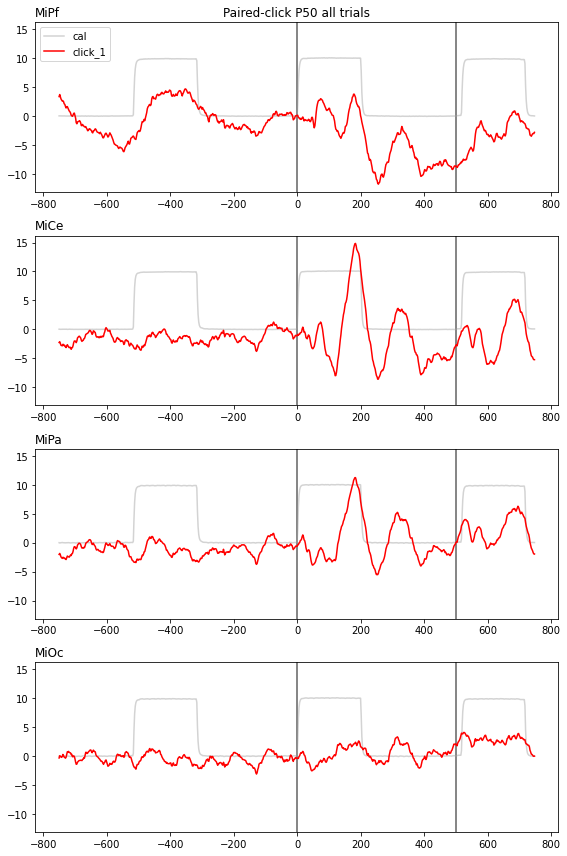

In [16]:
f, axs = plt.subplots(4, 1, figsize=(8,12), sharey=True)
colors = {"cal": "lightgray", "click_1": "red", "click_2": "green"}
for tag, erp in midline_erps.groupby('click'):
    for axi, chan in enumerate(midline):
        
        # mark onsets
        axs[axi].axvline(0, color='gray')
        axs[axi].axvline(click2_onset, color='gray')
        
        axs[axi].plot(
            erp["match_time"],
            erp[chan],
            color=colors[tag],
            label=tag,
        )
        
        # channel
        axs[axi].set_title(chan, loc='left')


axs[0].legend()
axs[0].set_title("Paired-click P50 all trials")
f.tight_layout()

**Single subject pipeline with epoch export in different formats**

build and calibrate the mkpy HDF5 format data file

1. get_event_table(*codemap*)
2. set_epoch_table(*name*, *event_table*, *pre*, *post*)
3. export_epochs(*name*, *file_format=...*)

In [ ]:
import warnings
warnings.filterwarnings("always", category=UserWarning)

# build mkpy.mkh5 format data file and calibrate
p50_h5 = mkh5.mkh5(p50_h5_f)
p50_h5.reset_all() 
p50_h5.create_mkdata("sub000", crw, log, yhdr)

p50_h5.append_mkdata("sub000", cals_crw, cals_log, cals_yhdr)

pts, pulse, lo, hi, ccode = 5, 10, -40, 40, 0
p50_h5.calibrate_mkdata(
    "sub000",  
    n_points=pts,  
    cal_size=pulse, 
    lo_cursor=lo,  
    hi_cursor=hi,  
    cal_ccode=ccode, 
)

# 1. scan event code pattern tags into the event table 
p50_event_table = p50_h5.get_event_table(MDE_HOME / "mkpy/p50_codemap.ytbl")


# use these to set the epoch table name, and pre, post stimulus boundaries
epoch_specs  = {
    "ms100": (-50, 50),
    "ms1500": (-750, 750),
    "ms3000": (-1500, 1500),
    "ms10000": (-5000, 5000),
}

for epoch_name, (pre, post) in epoch_specs.items():
    print(epoch_name, pre, post)
    
    # 2. set the epoch_table names and interval boundaries
    p50_h5.set_epochs(epoch_name, p50_event_table, pre, post)
    
    # multiple export formats for demonstration, in practice pick one format
    fformats = ["h5", "pdh5", "feather"]
    for ffmt in fformats:
        _fname = f"{MDE_HOME}/data/sub000p50.{epoch_name}.epochs.{ffmt}"
        print(f"exporting p50 {epoch_name} as {ffmt}: {_fname}")
        
        # 3.  export the epochs DATA ... EEG and events.
        p50_h5.export_epochs(epoch_name, _fname, file_format=ffmt)
        